## Feature Importance Analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-11-06 15:24:46.640548: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 15:24:48.221966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 15:24:50.204795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *
from sim import sim_run
from sim import plot

In [4]:
# overall imports
import importlib
import data

# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.sim_run
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.sim_run)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

In [5]:
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean', 'functional']
SFN_sim_path = os.getcwd() + '_backup/sim/sim_results/SFN_runs_mse'
os.listdir(SFN_sim_path)

['transcriptomePCA structural_ridge_random_8_gridsearch.pickle',
 'transcriptomePCA structural_pls_random_8_gridsearch.pickle',
 'transcriptome_pls_community101_42_gridsearch.pickle',
 'transcriptome functional_ridge_random_2_gridsearch.pickle',
 'transcriptomePCA_pls_community101_1_gridsearch.pickle',
 'transcriptome_xgboost_community102_1_bayessearch.pickle',
 'structural functional_ridge_random_1_gridsearch.pickle',
 'euclidean_ridge_random_42_gridsearch.pickle',
 'transcriptome euclidean_pls_random_9_gridsearch.pickle',
 'transcriptome euclidean_pls_random_42_gridsearch.pickle',
 'transcriptome euclidean_ridge_random_6_gridsearch.pickle',
 'transcriptomePCA_xgboost_community101_4_bayessearch.pickle',
 'transcriptomePCA structural functional_xgboost_community101_2_bayessearch.pickle',
 'structural_xgboost_random_2_bayessearch.pickle',
 'transcriptome structural_pls_random_3_gridsearch.pickle',
 'functional_xgboost_community102_3_bayessearch.pickle',
 'transcriptomePCA structural_rid

### For SFN xgboost experiments evaluate the most important features and their stability across CV folds


I want to evaluate the feature importances for a given simulation over all folds. recall the format of the results of a given simulation:
The user should be able to specify the input feature type, model type, and cross-validation type. 
Then the feature importances for each fold in each simulation should be saved to a data structure such as a dictionary.
This dict can then be used to plot the feature importances for all the folds over all the simulations on a single plot.

In [124]:
def load_filtered_results(base_path, input_features=None, split_type=None, model_type=None, search_type=None):
    """
    Load simulation results filtered by specified parameters.
    
    Parameters:
    -----------
    base_path : str
        Base path where pickle files are stored
    input_features : str or list, optional
        Input feature type(s) (e.g., 'transcriptome', 'structural', 'functional')
    split_type : str, optional
        Split type (e.g., 'random', 'community101', 'community102')
    model_type : str, optional
        Model type (e.g., 'xgboost', 'ridge', 'pls')
    search_type : str, optional
        Search type (e.g., 'gridsearch', 'bayessearch')
    
    Returns:
    --------
    list
        List of loaded results matching the specified criteria
    """
    # Get all pickle files
    all_files = [f for f in os.listdir(base_path) if f.endswith('.pickle')]
    filtered_files = all_files.copy()
    
    # Convert input_features to list if string
    if isinstance(input_features, str):
        input_features = [input_features]
    
    # Filter by input features
    if input_features:
        filtered_files = []
        for f in all_files:
            # Split filename by underscore and get feature part
            features = f.split('_')[0]
            # Check if features exactly match any of the input_features
            if features in input_features:
                # Ensure no additional features are present
                if len(f.split('_')[0].split()) == 1:
                    filtered_files.append(f)
    
    # Filter by model type
    if model_type:
        filtered_files = [f for f in filtered_files if model_type in f]
    
    # Filter by split type
    if split_type:
        filtered_files = [f for f in filtered_files if split_type in f]
    
    # Filter by search type
    if search_type:
        filtered_files = [f for f in filtered_files if search_type in f]
    
    
    # Load results
    results = []
    for file in filtered_files:
        print(f"Loading {file}")
        result = open_pickled_results(file, added_dir='SFN_runs_mse/', backup=True)
        results.append(result[0])
    
    return results

In [135]:
def compute_mean_feature_importances(results, combine_regions=False):
    """
    Computes the mean feature importances across all folds and simulations.

    Parameters:
    - results: List of lists containing simulation results, each with a dictionary that includes 'feature_importances'.
    - combine_regions: If True, averages the first and second half of features, assuming they represent the same genes
                      from two different regions. If False, keeps all features separate.

    Returns:
    - mean_importances: A numpy array containing the mean importance for each feature.
    """
    # Initialize a list to collect all feature importances
    all_importances = []

    # Step 1: Extract feature importances
    for sim_result in results:
        for fold_result in sim_result:
            # Assuming fold_result is a dictionary containing 'feature_importances'
            feature_importances = fold_result['feature_importances']
            all_importances.append(feature_importances)
    
    # Convert to a numpy array for easier manipulation
    all_importances = np.array(all_importances)
    
    # Step 2: Calculate the mean importance for each feature
    mean_importances = np.mean(all_importances, axis=0)
    
    # Step 3: Optionally combine regions
    if combine_regions:
        n_features = len(mean_importances)
        if n_features % 2 != 0:
            raise ValueError("Number of features must be even to combine regions")
            
        half_length = n_features // 2
        mean_importances = (mean_importances[:half_length] + mean_importances[half_length:]) / 2
    
    return mean_importances

def plot_mean_feature_importances(mean_importances, combine_regions=False):
    """
    Plots the mean feature importances as a bar plot.

    Parameters:
    - mean_importances: A numpy array containing the mean importance for each feature.
    - combine_regions: Boolean indicating whether the importances represent combined regions.
                      Affects the x-axis labeling.
    """
    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(len(mean_importances)), mean_importances, width=2.0, edgecolor='none')
    
    title = 'Average Feature Importances Across All Folds and Simulations'
    if combine_regions:
        title += ' (Combined Regions)'
    plt.title(title)
    
    xlabel = 'Gene Index' if combine_regions else 'Feature Index'
    plt.xlabel(xlabel)
    plt.ylabel('Average Importance')
    plt.tight_layout()  # Optimize layout to reduce rendering time
    plt.show()

def plot_feature_importances_with_folds(results, combine_regions=False, show_mean=True, sim_idx=None):
    """
    Plots individual fold feature importances as translucent bars with optional mean importance overlay.
    
    Parameters:
    - results: List of simulation results containing feature importances for each fold
    - combine_regions: Boolean indicating whether to combine region importances
    - show_mean: Boolean indicating whether to show the mean importance overlay
    - sim_idx: Optional index of specific simulation to plot. If None, plots all simulations.
    """
    # Get mean importances using existing function
    mean_importances = compute_mean_feature_importances(results, combine_regions=combine_regions)
    
    # Extract fold importances
    all_importances = []
    if sim_idx is not None:
        if sim_idx >= len(results):
            raise ValueError(f"sim_idx {sim_idx} is out of range for results of length {len(results)}")
        sim_result = results[sim_idx]
        for fold_result in sim_result:
            feature_importances = fold_result['feature_importances']
            if combine_regions:
                n_features = len(feature_importances)
                half_length = n_features // 2
                combined_importances = (feature_importances[:half_length] + 
                                      feature_importances[half_length:]) / 2
                all_importances.append(combined_importances)
            else:
                all_importances.append(feature_importances)
    else:
        for sim_result in results:
            for fold_result in sim_result:
                feature_importances = fold_result['feature_importances']
                if combine_regions:
                    n_features = len(feature_importances)
                    half_length = n_features // 2
                    combined_importances = (feature_importances[:half_length] + 
                                          feature_importances[half_length:]) / 2
                    all_importances.append(combined_importances)
                else:
                    all_importances.append(feature_importances)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    x = np.arange(len(mean_importances))
    
    # Plot each fold's importances as translucent blue bars
    for fold_importance in all_importances:
        plt.bar(x, fold_importance, width=2.0, color='blue', alpha=0.1, edgecolor='none')
    
    # Optionally plot mean importance overlay
    if show_mean:
        plt.bar(x, mean_importances, width=1.0, color='red', alpha=1.0, edgecolor='none',
                label='Mean Importance')

    title = 'Feature Importances Across '
    title += f'Simulation {sim_idx} ' if sim_idx is not None else 'All Simulations '
    title += 'and Folds'
    if combine_regions:
        title += ' (Combined Regions)'
    plt.title(title)
    
    xlabel = 'Gene Index' if combine_regions else 'Feature Index'
    plt.xlabel(xlabel)
    plt.ylabel('Importance')
    if show_mean:
        plt.legend()
    plt.tight_layout()
    plt.show()

#### Random CV Split TranscriptomePCA

Loading transcriptomePCA_xgboost_random_2_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_7_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_8_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_1_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_5_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_42_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_6_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_3_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_9_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_4_bayessearch.pickle


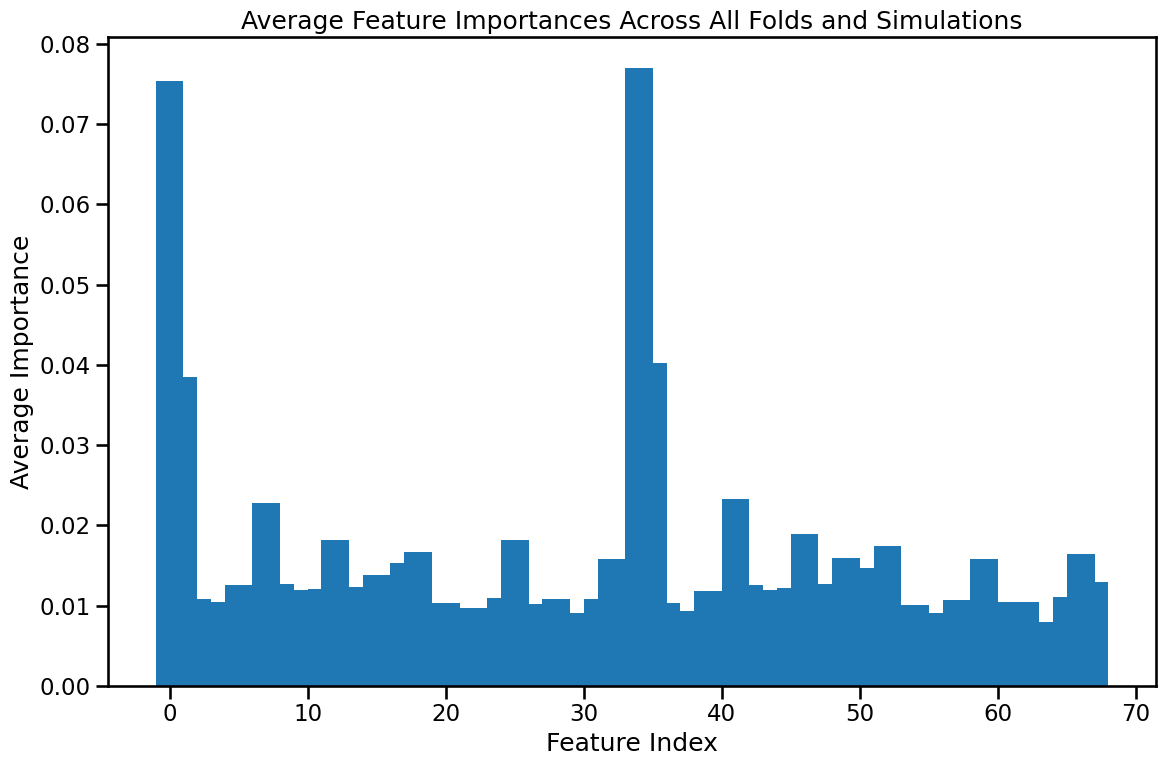

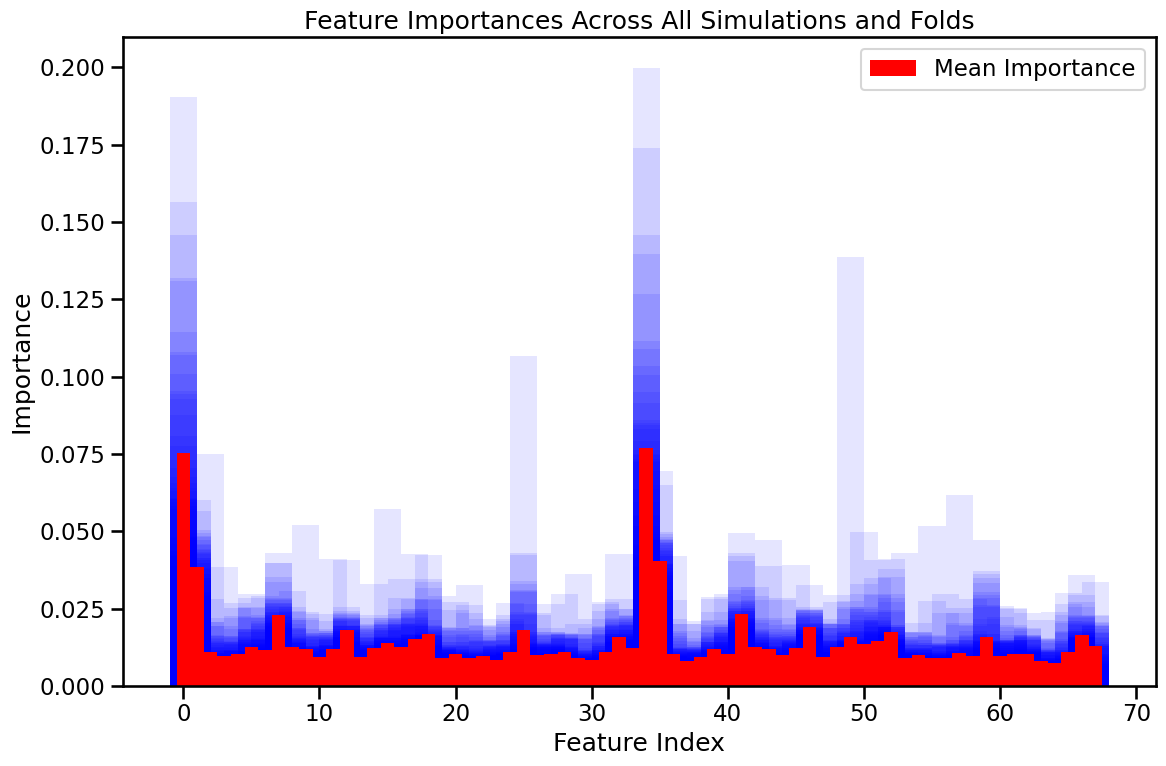

In [136]:
results = load_filtered_results(
    base_path=SFN_sim_path,
    input_features=['transcriptomePCA'],  # Can be single string or list
    split_type='random',
    model_type='xgboost',
    search_type='bayessearch'
)

combine_regions=False
mean_importances = compute_mean_feature_importances(results, combine_regions=combine_regions)

plot_mean_feature_importances(mean_importances, combine_regions=combine_regions)
plot_feature_importances_with_folds(results, combine_regions=combine_regions, show_mean=True, sim_idx=None)


#### Community CV Split transcriptomePCA

Loading transcriptomePCA_xgboost_community101_4_bayessearch.pickle
Loading transcriptomePCA_xgboost_community102_1_bayessearch.pickle
Loading transcriptomePCA_xgboost_community102_5_bayessearch.pickle
Loading transcriptomePCA_xgboost_community101_5_bayessearch.pickle
Loading transcriptomePCA_xgboost_community102_2_bayessearch.pickle
Loading transcriptomePCA_xgboost_community101_1_bayessearch.pickle
Loading transcriptomePCA_xgboost_community101_42_bayessearch.pickle
Loading transcriptomePCA_xgboost_community101_2_bayessearch.pickle
Loading transcriptomePCA_xgboost_community102_3_bayessearch.pickle
Loading transcriptomePCA_xgboost_community102_4_bayessearch.pickle
Loading transcriptomePCA_xgboost_community101_3_bayessearch.pickle
Loading transcriptomePCA_xgboost_community102_42_bayessearch.pickle


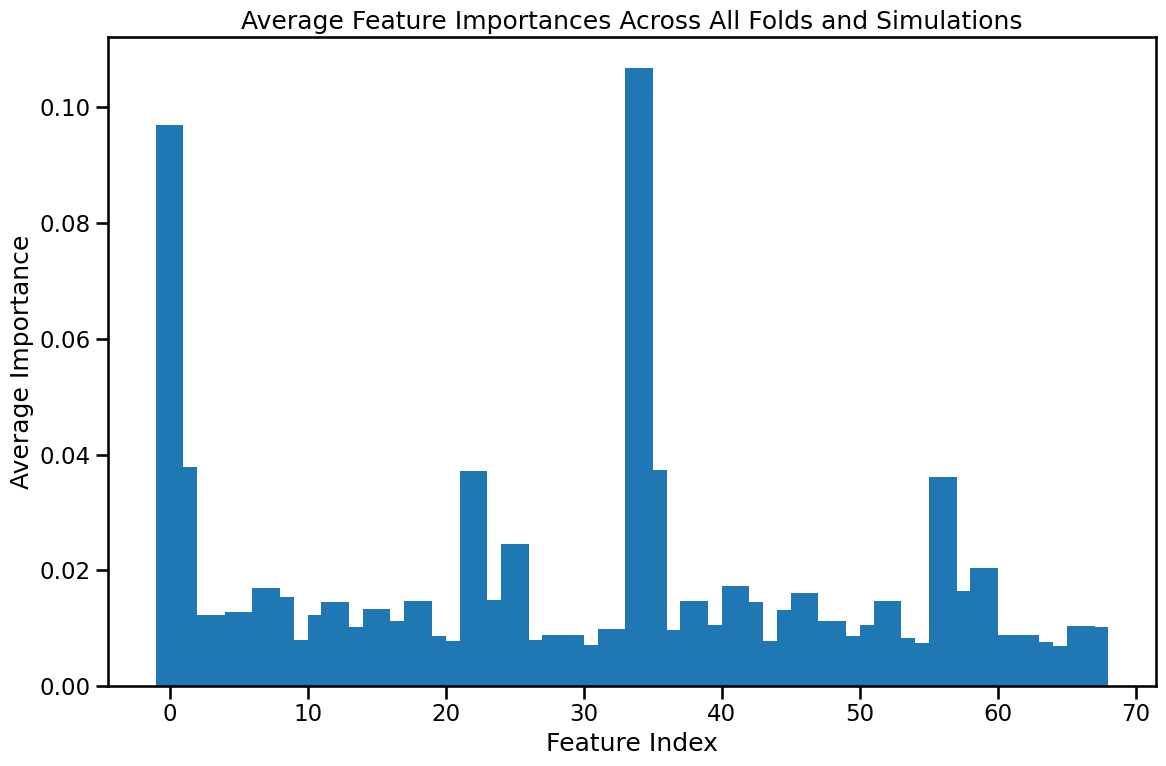

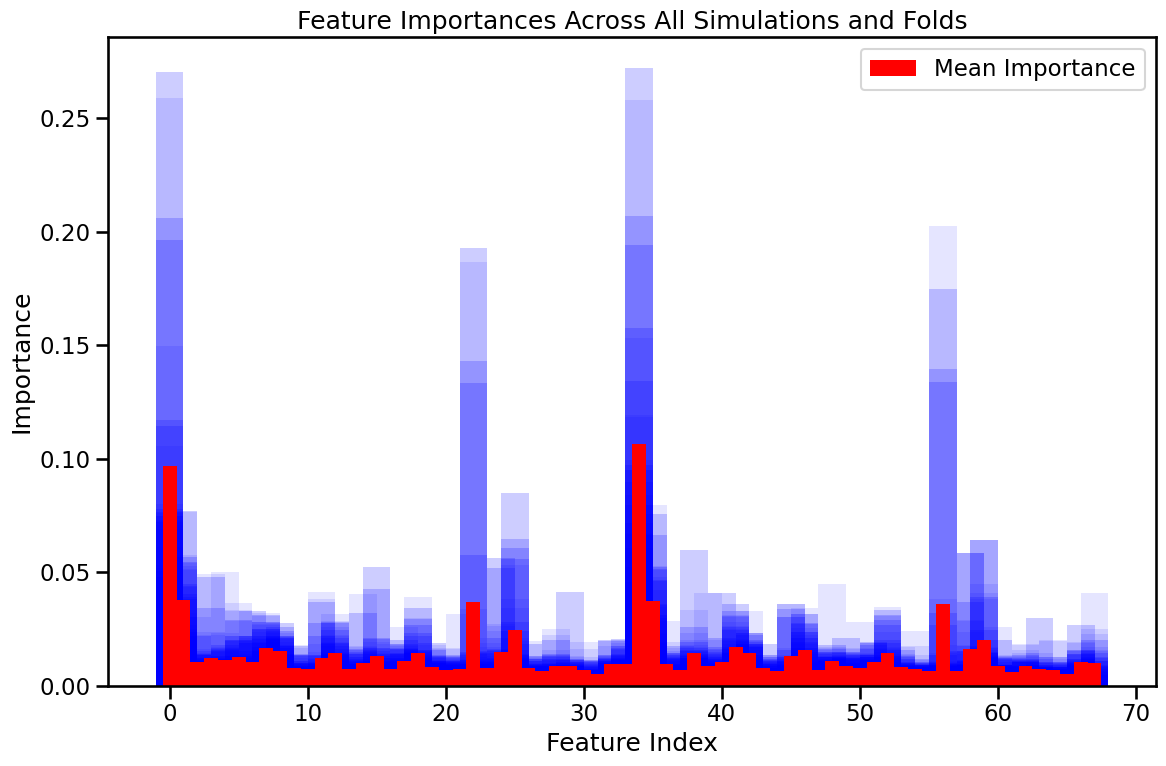

In [137]:
results = load_filtered_results(
    base_path=SFN_sim_path,
    input_features=['transcriptomePCA'],  # Can be single string or list
    split_type='community',
    model_type='xgboost',
    search_type='bayessearch'
)

combine_regions=False
mean_importances = compute_mean_feature_importances(results, combine_regions=combine_regions)

plot_mean_feature_importances(mean_importances, combine_regions=combine_regions)
plot_feature_importances_with_folds(results, combine_regions=combine_regions, show_mean=True, sim_idx=None)


#### Random CV Split Structural

Loading structural_xgboost_random_2_bayessearch.pickle
Loading structural_xgboost_random_5_bayessearch.pickle
Loading structural_xgboost_random_3_bayessearch.pickle
Loading structural_xgboost_random_1_bayessearch.pickle
Loading structural_xgboost_random_9_bayessearch.pickle
Loading structural_xgboost_random_7_bayessearch.pickle
Loading structural_xgboost_random_8_bayessearch.pickle
Loading structural_xgboost_random_6_bayessearch.pickle
Loading structural_xgboost_random_4_bayessearch.pickle
Loading structural_xgboost_random_42_bayessearch.pickle


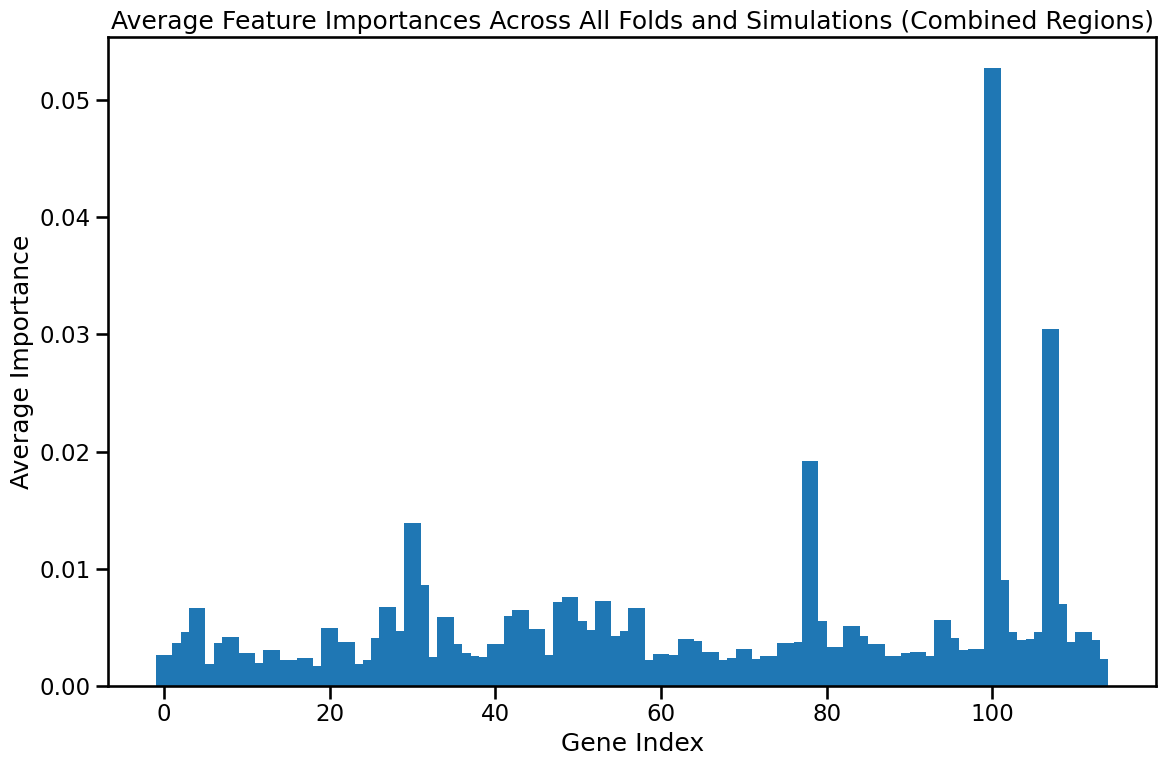

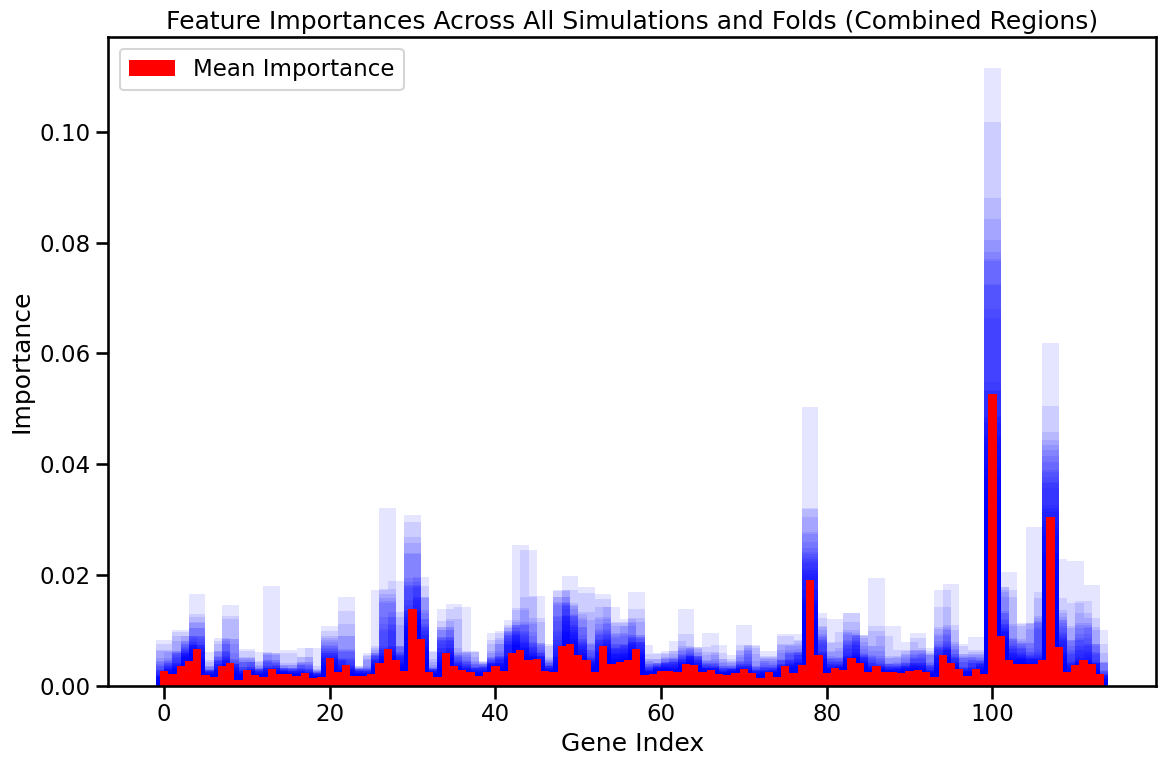

In [138]:
results = load_filtered_results(
    base_path=SFN_sim_path,
    input_features=['structural'],  # Can be single string or list
    split_type='random',
    model_type='xgboost',
    search_type='bayessearch'
)

combine_regions=True
mean_importances = compute_mean_feature_importances(results, combine_regions=combine_regions)

plot_mean_feature_importances(mean_importances, combine_regions=combine_regions)
plot_feature_importances_with_folds(results, combine_regions=combine_regions, show_mean=True, sim_idx=None)


#### Community CV Split structural

In [ ]:
### CONTINUE FROM HERE

In [139]:
results = load_filtered_results(
    base_path=SFN_sim_path,
    input_features=['structural'],  # Can be single string or list
    split_type='random',
    model_type='pls',
    search_type='bayessearch'
)

combine_regions=False
mean_importances = compute_mean_feature_importances(results, combine_regions=combine_regions)

plot_mean_feature_importances(mean_importances, combine_regions=combine_regions)
plot_feature_importances_with_folds(results, combine_regions=combine_regions, show_mean=True, sim_idx=None)


TypeError: object of type 'numpy.float64' has no len()

<Figure size 1200x800 with 0 Axes>

In [115]:
plot_feature_importances_with_folds(results, combine_regions=combine_regions, show_mean=True, sim_idx=0)


TypeError: object of type 'numpy.float64' has no len()

In [116]:
plot_feature_importances_with_folds(results, combine_regions=combine_regions, show_mean=True, sim_idx=5)


TypeError: object of type 'numpy.float64' has no len()